# main program

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os
from torch import nn, optim
from torch.utils.data import Subset, DataLoader

# 配置模型和数据集路径、类别等信息
dataset_paths = {
    'cifar-10': '../data/cifar-10',
    'cifar-100': '../data/cifar-100',
    'animals-10': '../data/animals-10',
    'tiny-imagenet-200': '../data/tiny-imagenet-200',
}

num_classes_dict = {
    'cifar-10': 10,
    'cifar-100': 100,
    'animals-10': 10,
    'tiny-imagenet-200': 200
}

selected_classes_dict = {
    'cifar-10': [0, 1, 2, 3, 4],  # 选择 5 个类别进行操作
    'cifar-100': [i for i in range(10)],  # 选择 10 个类别进行操作
    'animals-10': [0, 1, 2, 3, 4],  # 选择 5 个类别进行操作
    'tiny-imagenet-200': [i for i in range(10)],  # 选择 10 个类别进行操作
}

def get_dataset(dataset_name):
    # 根据不同的数据集进行加载
    if dataset_name == 'cifar-10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        train_dataset = torchvision.datasets.CIFAR10(root=dataset_paths[dataset_name], train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root=dataset_paths[dataset_name], train=False, download=True, transform=transform)
    elif dataset_name == 'cifar-100':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        train_dataset = torchvision.datasets.CIFAR100(root=dataset_paths[dataset_name], train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR100(root=dataset_paths[dataset_name], train=False, download=True, transform=transform)
    # Animals-10 和 Tiny-ImageNet 数据集的加载方式类似，假设数据结构一致
    # 如果数据集结构不同，可以自定义加载方法
    else:
        raise ValueError("Unsupported dataset: " + dataset_name)
    
    return train_dataset, test_dataset

# 移除指定类别 50% 的样本
def remove_50_percent_of_selected_classes(dataset, selected_classes, remove_fraction=0.5):
    class_indices = {i: [] for i in selected_classes}
    
    for idx, (_, label) in enumerate(dataset):
        if label in selected_classes:
            class_indices[label].append(idx)
    
    removed_indices = []
    for label in selected_classes:
        indices = class_indices[label]
        removed_indices.extend(random.sample(indices, int(len(indices) * remove_fraction)))
    
    # 保留剩余样本
    remaining_indices = list(set(range(len(dataset))) - set(removed_indices))
    return Subset(dataset, remaining_indices)

# 为指定类别的 10% 样本添加噪声
def add_noise_to_selected_classes(dataset, selected_classes, noise_fraction=0.1):
    noisy_data = []
    noisy_labels = []
    
    for idx, (image, label) in enumerate(dataset):
        # 只为选定的类别添加噪声
        if label in selected_classes and random.random() < noise_fraction:
            noise = torch.randn_like(image) * 0.1  # 添加噪声
            image = image + noise
            image = torch.clamp(image, -1, 1)  # 确保图像仍在合法范围内
        noisy_data.append(image)
        noisy_labels.append(label)
    
    return list(zip(noisy_data, noisy_labels))

# 定义 ResNet 模型
def create_resnet_model(num_classes):
    model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
    return model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 定义损失函数和优化器
def get_criterion_and_optimizer(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return criterion, optimizer

# 创建保存路径 (models/模型名称/数据集名称/情况)
def create_save_path(model_name, dataset_name, condition):
    save_dir = os.path.join('../models', model_name, dataset_name, condition)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

# 训练模型并在最后保存
def train_and_save(model, train_loader, criterion, optimizer, save_path, num_epochs=10):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 梯度清零
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # 保存最终的模型权重
    torch.save(model.state_dict(), os.path.join(save_path, f'{model_name}_{dataset_name}_final.pth'))
    print(f"模型已保存到 {os.path.join(save_path, f'{model_name}_{dataset_name}_final.pth')}")

# 测试模型
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {100 * correct / total}%")

# 训练的封装
def run_experiment(dataset_name, model_name, selected_classes, condition):
    # 获取数据集
    train_dataset, test_dataset = get_dataset(dataset_name)
    
    # 原始数据集
    if condition == 'original_data':
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    # 移除 50% 数据集
    elif condition == 'removed_50_percent':
        train_dataset_shifted = remove_50_percent_of_selected_classes(train_dataset, selected_classes)
        train_loader = DataLoader(train_dataset_shifted, batch_size=64, shuffle=True, num_workers=2)
    # 添加噪声数据集
    elif condition == 'noisy_data':
        train_dataset_shifted = remove_50_percent_of_selected_classes(train_dataset, selected_classes)
        noisy_train_data = add_noise_to_selected_classes(train_dataset_shifted, selected_classes)
        train_loader = DataLoader(noisy_train_data, batch_size=64, shuffle=True, num_workers=2)
    else:
        raise ValueError("Unsupported condition: " + condition)
    
    # 构建模型
    num_classes = num_classes_dict[dataset_name]
    model = create_resnet_model(num_classes)
    
    # 损失函数和优化器
    criterion, optimizer = get_criterion_and_optimizer(model)
    
    # 创建保存路径
    save_path = create_save_path(model_name, dataset_name, condition)
    
    # 训练并保存模型
    train_and_save(model, train_loader, criterion, optimizer, save_path)
    
    # 测试模型
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    test(model, test_loader)

# 调用三种情况的实验
# for dataset in ['cifar-10', 'cifar-100', 'animals-10', 'tiny-imagenet-200']:
# for dataset in ['cifar-10', 'cifar-100',]:
for dataset in ['cifar-10', ]:
    
    print(f"开始 {dataset} 的原始数据集训练")
    run_experiment(dataset, 'resnet18', selected_classes_dict[dataset], 'original_data')
    
    print(f"\n开始 {dataset} 的移除 50% 数据的训练")
    run_experiment(dataset, 'resnet18', selected_classes_dict[dataset], 'removed_50_percent')
    
    print(f"\n开始 {dataset} 的添加噪声数据的训练")
    run_experiment(dataset, 'resnet18', selected_classes_dict[dataset], 'noisy_data')


开始 cifar-10 的原始数据集训练
Files already downloaded and verified
Files already downloaded and verified


/nvme/szh/envs/apbench/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nvme/szh/envs/apbench/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.3711955482545106
Epoch [2/10], Loss: 0.9755244271834488
Epoch [3/10], Loss: 0.7969691714514857
Epoch [4/10], Loss: 0.6763285422111716
Epoch [5/10], Loss: 0.5753873122660705
Epoch [6/10], Loss: 0.48430625494102686
Epoch [7/10], Loss: 0.3951370992585826
Epoch [8/10], Loss: 0.32629297603198026
Epoch [9/10], Loss: 0.2692428531168062
Epoch [10/10], Loss: 0.2111281946234767


NameError: name 'model_name' is not defined

# dataset exploration

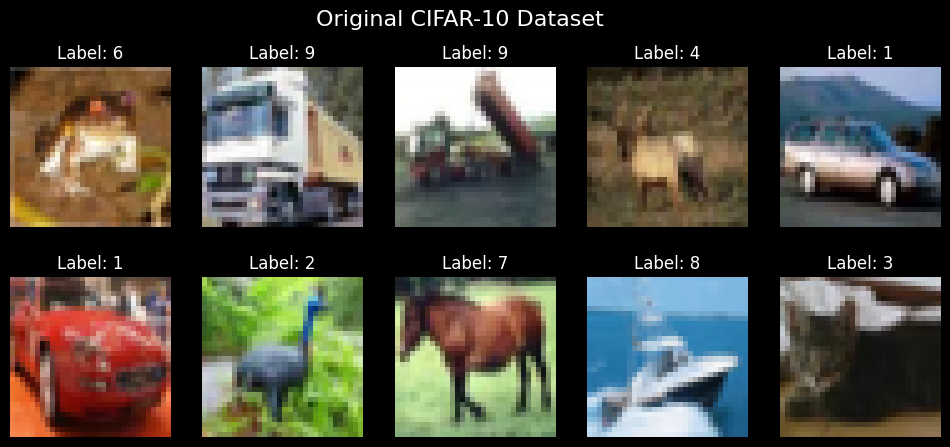

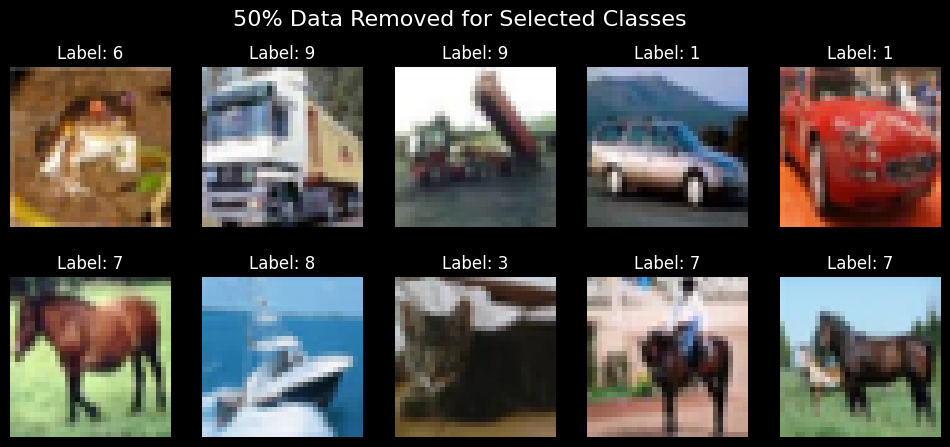

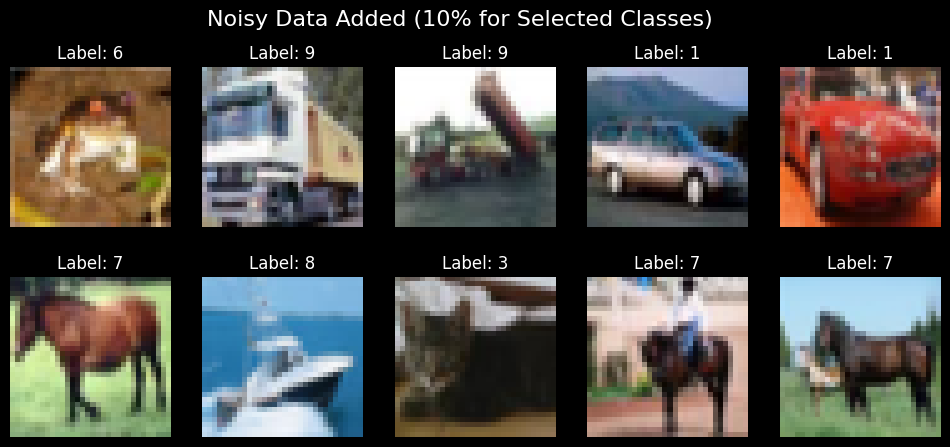

In [6]:
import matplotlib.pyplot as plt

# 可视化函数：显示一组图片
def show_images(dataset, title):
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axs.flatten()):
        img, label = dataset[i]
        img = img / 2 + 0.5  # 反归一化
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# 展示原始数据集
show_images(train_dataset, "Original CIFAR-10 Dataset")

# 展示移除50%数据后的数据集
train_dataset_shifted = remove_50_percent_of_selected_classes(train_dataset, selected_classes)
show_images(train_dataset_shifted, "50% Data Removed for Selected Classes")

# 展示添加噪声后的数据集
noisy_train_data = add_noise_to_selected_classes(train_dataset_shifted, selected_classes)
show_images(noisy_train_data, "Noisy Data Added (10% for Selected Classes)")

# list torch datasets

In [12]:
import torchvision.datasets as datasets

# List all datasets in torchvision
all_datasets = [dataset for dataset in dir(datasets) if not dataset.startswith("__")]

# Print all datasets in torchvision
for dataset in all_datasets:
    print(dataset)



CIFAR10
CIFAR100
CLEVRClassification
CREStereo
Caltech101
Caltech256
CarlaStereo
CelebA
Cityscapes
CocoCaptions
CocoDetection
Country211
DTD
DatasetFolder
EMNIST
ETH3DStereo
EuroSAT
FER2013
FGVCAircraft
FakeData
FallingThingsStereo
FashionMNIST
Flickr30k
Flickr8k
Flowers102
FlyingChairs
FlyingThings3D
Food101
GTSRB
HD1K
HMDB51
INaturalist
ImageFolder
ImageNet
Imagenette
InStereo2k
KMNIST
Kinetics
Kitti
Kitti2012Stereo
Kitti2015Stereo
KittiFlow
LFWPairs
LFWPeople
LSUN
LSUNClass
MNIST
Middlebury2014Stereo
MovingMNIST
Omniglot
OxfordIIITPet
PCAM
PhotoTour
Places365
QMNIST
RenderedSST2
SBDataset
SBU
SEMEION
STL10
SUN397
SVHN
SceneFlowStereo
Sintel
SintelStereo
StanfordCars
UCF101
USPS
VOCDetection
VOCSegmentation
VisionDataset
WIDERFace
_optical_flow
_stereo_matching
caltech
celeba
cifar
cityscapes
clevr
coco
country211
dtd
eurosat
fakedata
fer2013
fgvc_aircraft
flickr
flowers102
folder
food101
gtsrb
hmdb51
imagenet
imagenette
inaturalist
kinetics
kitti
lfw
lsun
mnist
moving_mnist
omniglot